This notebook runs experiments on comparing the difference between time used by three forking methods

1. Copying a coroutine
2. Copying a process
3. Replaying a coroutine

by [**Kai Xu**](http://xukai92.github.io/) on **07/10/2016**

Let's start by loading some essential packages: `Gadfly` for plotting and aimed forking methods from `Turing`.

In [1]:
using Gadfly, DataFrames
import Turing: TraceC, TraceR, fork

    +(AbstractArray, DataArrays.DataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.


Functions below are used to compute statics for plotting

In [2]:
function stds(times)
    map(v -> std([Float64(t) for t in v]), times)
end

function means(times)
    map(v -> mean(v), times)
end;

At different running time of the task, a batch of tasks are forked, and the time of forking each task is recorded. 

The function below did this batch forking process and returns the times.

In [3]:
function batch_copy(trace, num)
    times = Vector()
    for _ = 1:num
        push!(times, @elapsed fork(trace))
    end
    return times
end;

It would be straightforward to run the experiment on an array versin of Fibonaaci, which is defined as below.

In [4]:
function fib_stack()
    stack = Array{Int}(depth_max)
    ith = 1
    while true
        if ith == 1 || ith == 2
            stack[ith] = 1
        else
            stack[ith] = stack[ith - 1] + stack[ith - 2]
        end
        produce(stack[ith])
    end
end

fib_stack (generic function with 1 method)

In [63]:
depth_max = 50
num = 10

trace = TraceC(fib_stack)

coroutine_times = Array{Vector}(depth_max)
for depth = 1:depth_max
    coroutine_times[depth] = batch_copy(trace, num)
    consume(trace)
end
coroutine_times = coroutine_times .* 1000

trace = TraceR(fib_stack)

replaying_times = Array{Vector}(depth_max)
for depth = 1:depth_max
    replaying_times[depth] = batch_copy(trace, num)
    consume(trace)
end
replaying_times = replaying_times .* 1000;

Read and convert DataFrame to Array of Vector

In [6]:
df = readtable("./fork/array.csv", separator = ';', header = false)
process_times = Array{Vector}(depth_max)
for i = 1:depth_max
    process_times[i] = Vector([t for t in convert(Array, df[i,:])]) .* 1000
end

And same, the plot.

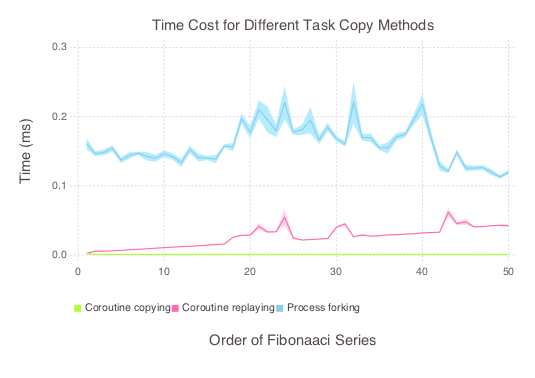

In [64]:
coroutine_means = means(coroutine_times)
coroutine_stds = stds(coroutine_times)
coroutine_mins = coroutine_means .- (1.96 * coroutine_stds / sqrt(depth_max))
coroutine_maxs = coroutine_means .+ (1.96 * coroutine_stds / sqrt(depth_max))

coroutine_layer = layer(
    x=1:depth_max, y=coroutine_means, ymin=coroutine_mins, ymax=coroutine_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"greenyellow")
)

replaying_means = means(replaying_times)
replaying_stds = stds(replaying_times)
replaying_mins = replaying_means - (1.96 * replaying_stds / sqrt(depth_max))
replaying_maxs = replaying_means + (1.96 * replaying_stds / sqrt(depth_max))

replaying_layer = layer(
    x=1:depth_max, y=replaying_means, ymin=replaying_mins, ymax=replaying_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"hotpink")
)

process_means = means(process_times)
process_stds = stds(process_times)
process_mins = process_means - (1.96 * process_stds / sqrt(depth_max))
process_maxs = process_means + (1.96 * process_stds / sqrt(depth_max))

process_layer = layer(
    x=1:depth_max, y=process_means, ymin=process_mins, ymax=process_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"skyblue")
)

p_stack = plot(
    coroutine_layer, replaying_layer, process_layer,
    Guide.manual_color_key("",["Coroutine copying","Coroutine replaying", "Process forking"], ["greenyellow", "hotpink", "skyblue"]),
Theme(key_position=:bottom),
    Guide.xlabel("Order of Fibonaaci Series"), Guide.ylabel("Time (ms)"),
    Guide.title("Time Cost for Different Task Copy Methods"),

)

And again save the plot.

In [18]:
draw(PDF("exp2array.pdf", 5inch, 3.75inch), p_stack)

> Environment:
- OS: macOS Sierra v10.12
- Machine: MacBook Pro (Retina, 13-inch, Late 2013)
- Processor: 2.4 GHz Intel Core i5
- Memory: 8 GB 16000 MHz DDR3
- Graphics:Intel Iris 1536 MB

> Note: the limit of the number of child processes could be forked by users on macOS from C is 709.